In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-features/alzheimer.csv


Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

   Converted       1.00      0.18      0.31        11
    Demented       0.94      1.00      0.97        32
 Nondemented       0.79      0.97      0.87        32

    accuracy                           0.87        75
   macro avg       0.91      0.72      0.72        75
weighted avg       0.89      0.87      0.83        75


Confusion Matrix:
[[ 2  1  8]
 [ 0 32  0]
 [ 0  1 31]]


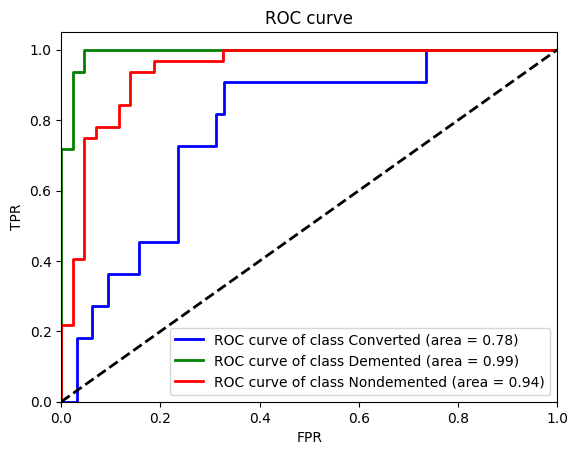

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

#loading dataset, separating into X and y, and splitting it into test and train
d = pd.read_csv('/kaggle/input/alzheimer-features/alzheimer.csv')
X = d.drop('Group', axis=1)
y = d['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#finding the numeric and string type columns
nc = X.select_dtypes(include=['int64', 'float64']).columns
cc = X.select_dtypes(include=['object']).columns


# Pipelines for Numeric and String type columns

#making a pipleine for numeric columns and imputing missing values with mean and scale
#helps us sequentially apply imputations and scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())   #removes mean and standardizes to unit value
])
#making pipleine for string type columns using one-hot encoding.
#helps us sequentially apply imputations and encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  #replacing blank with the most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  #ignore new types of data not seen during training.
])
#combine all of the steps in preprocessing by applying different preprocessing to different subsets
prep = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nc),   #applies numeric_transformer to nc
        ('cat', categorical_transformer, cc)  #applies categorical_transformer to cc
    ])

#APPLYING THE ENTIRE PIPELINE
#making pipeline with preprocessing and logistic regression and fitting it, then predicting on the test set.
pipeline = Pipeline(steps=[('preprocessor', prep),
                           ('classifier', LogisticRegression(max_iter=1000))])
pipeline.fit(X_train, y_train)
ypred = pipeline.predict(X_test)

#evaluating the model
accuracy = accuracy_score(y_test, ypred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report(y_test, ypred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, ypred))

#making output labels binary to plot ROC curve
ybin = label_binarize(y_test, classes=pipeline.classes_)
nclass = ybin.shape[1]
#predicting probabilities
yscore = pipeline.decision_function(X_test)
#finding ROC curve and areas for each curve
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(nclass):
    fpr[i], tpr[i],a = roc_curve(ybin[:, i], yscore[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(nclass), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {pipeline.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


SVM Accuracy: 0.84

SVM Classification Report:
              precision    recall  f1-score   support

   Converted       0.50      0.18      0.27        11
    Demented       0.94      0.94      0.94        32
 Nondemented       0.79      0.97      0.87        32

    accuracy                           0.84        75
   macro avg       0.74      0.70      0.69        75
weighted avg       0.81      0.84      0.81        75


SVM Confusion Matrix:
[[ 2  1  8]
 [ 2 30  0]
 [ 0  1 31]]


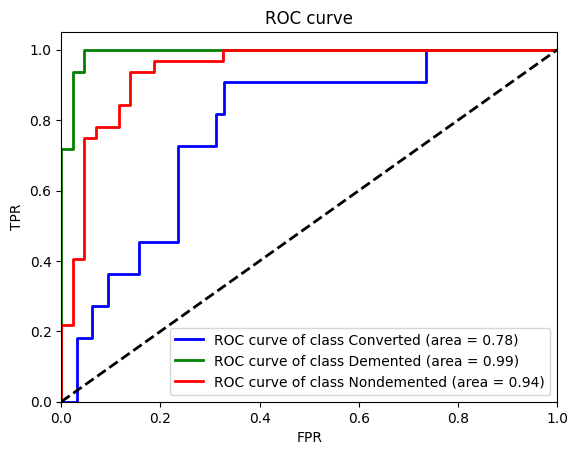

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

#loading the dataset, separating it into X and y, then splitting it into test and train set.
d = pd.read_csv('/kaggle/input/alzheimer-features/alzheimer.csv')
X = d.drop('Group', axis=1)
y = d['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#finidng the numerical and string type columns
nc = X.select_dtypes(include=['int64', 'float64']).columns
cc = X.select_dtypes(include=['object']).columns


#making pipeline for numeric and string type columns.

#imputing missing values with mean.
#sequentially applying imputation and scaling 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
#one-hot encoding for the string type columns.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #replaing blank value with most frequent value
    ('encoder', OneHotEncoder(handle_unknown='ignore'))   #ignore new types of data unseen during training
])
#combine all of the steps in preprocessing by applying different preprocessing to different subsets
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nc),
        ('cat', categorical_transformer, cc)
    ])

#APPLYING PIPELINE
#making pipeline for SVM classifier and preprocessing, then fitting it and predicting on test set.
svmpipe = Pipeline(steps=[('preprocessor', prep),
                               ('classifier', SVC(kernel='linear'))])   #linear is better than RBF and poly
svmpipe.fit(X_train, y_train)
y_pred_svm = svmpipe.predict(X_test)

#evalulating the model.
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')
print('\nSVM Classification Report:')
print(classification_report(y_test, y_pred_svm))
print('\nSVM Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))


#making output labels binary to plot ROC curve
ybin = label_binarize(y_test, classes=pipeline.classes_)
nclass = ybin.shape[1]
#predicting probabilities
yscore = pipeline.decision_function(X_test)
#finding ROC curve and areas for each curve
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(nclass):
    fpr[i], tpr[i],a = roc_curve(ybin[:, i], yscore[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(nclass), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {pipeline.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Decision Tree Accuracy: 0.84

Decision Tree Classification Report:
              precision    recall  f1-score   support

   Converted       0.33      0.09      0.14        11
    Demented       0.91      0.94      0.92        32
 Nondemented       0.82      1.00      0.90        32

    accuracy                           0.84        75
   macro avg       0.69      0.68      0.66        75
weighted avg       0.79      0.84      0.80        75


Decision Tree Confusion Matrix:
[[ 1  3  7]
 [ 2 30  0]
 [ 0  0 32]]


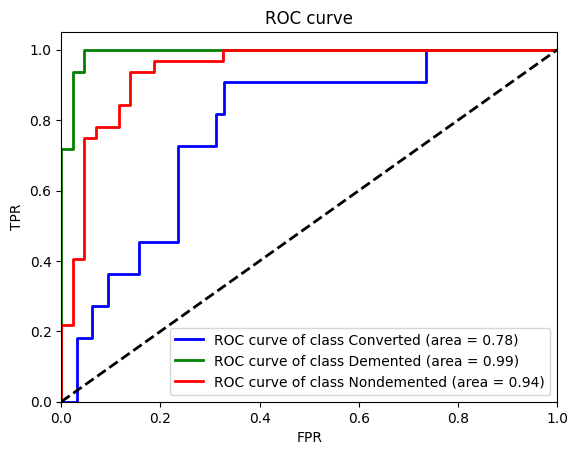

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

#loading dataset, separating into X and y, then splitting it into test and train sets.
data = pd.read_csv('/kaggle/input/alzheimer-features/alzheimer.csv')
X = data.drop('Group', axis=1)
y = data['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#finding numeric and string type columns.
nc = X.select_dtypes(include=['int64', 'float64']).columns
cc = X.select_dtypes(include=['object']).columns

#making pipelines
#pipeline for numeric values by using mean value for missing values.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())    #removes the mean and standardizes to unit Value
])

#pipeline for string values using one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), #replacing blank with most frequent values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))   #ignore new unseen types of data
])
#combining both the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nc),
        ('cat', categorical_transformer, cc)
    ])

#APPLYING THE ENTIRE PIPELINE
#making pipeline with decision tree and the preprocessing and fitting it, then predicting it
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier())])
dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_test)

#evaluating the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print('\nDecision Tree Classification Report:')
print(classification_report(y_test, y_pred_dt))
print('\nDecision Tree Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_dt))


#making output labels binary to plot ROC curve
ybin = label_binarize(y_test, classes=pipeline.classes_)
nclass = ybin.shape[1]
#predicting probabilities
yscore = pipeline.decision_function(X_test)
#finding ROC curve and areas for each curve
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(nclass):
    fpr[i], tpr[i],a = roc_curve(ybin[:, i], yscore[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting all ROC curves
plt.figure()
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(nclass), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {pipeline.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
